In [1]:
# Importing Packages
import pandas as pd
import numpy as np
import os
import shutil

In [2]:
# Defining File Paths #
file_path    = 'galaxy_data/'             # Parent File Path
mapping_file = 'gz2_filename_mapping.csv' # Mapping File Path
hart16       = 'gz2_hart16.csv'           # Hart File Path
image_path   = 'images_gz2/images/'       # Image Folder Path

In [3]:
if os.path.exists(file_path+image_path+ 'z'):
    os.remove(file_path+image_path+ 'z')
if os.path.exists(file_path+image_path+ 'results_public.txt'):
    os.remove(file_path+image_path+ 'results_public.txt')
if os.path.exists(file_path+image_path+ 'results.txt'):
    os.remove(file_path+image_path+ 'results.txt')

Section 1: File Management

In [4]:
mf           = pd.read_csv(file_path + mapping_file) # Reading in CSV Mapping File
hf           = pd.read_csv(file_path + hart16)       # Reading in CSV Hart File

In [5]:
galaxy_class = hf['gz2_class']                                                  
galaxy_ID    = hf['dr7objid']                                                   

# Organizes the ID number based on the Class of the Object

# General

# Spiral: 	1.) If class string starts with S		
#		3.) If class string contains number of arms (1,2,3,4,+,?)
#		4.) If class contains (t,m,l) = (tight, medium, loose)

		
		
# Elliptical: If class string starts with E

# Irregular: If last of class string contains the string "(i)"

def organize_class(class_arr, obID_arr, frac):
    data         = pd.concat([class_arr, obID_arr], axis=1)
    data.columns = ['Class', 'ID']
    
    not_classes  = ['(r)', '(l)', '(d)', '(i)', '(o)', '(m)', '(u)']
    
    
    irr_data     = data[data['Class'].str.endswith('(i)')].sample(frac = frac, random_state = 42)
    ellip_data   = data[data['Class'].str.startswith('E') & ~data['Class'].str.endswith(tuple(not_classes))].sample(frac = frac, random_state = 42)
    spiral_data  = data[data['Class'].str.startswith('S') & ~data['Class'].str.endswith(tuple(not_classes))].sample(frac = frac, random_state = 42)
       
    not_classified_data = data[~data['ID'].isin(spiral_data['ID']) & ~data['ID'].isin(ellip_data['ID'])]
    
    return spiral_data, ellip_data, irr_data, not_classified_data

# Defines are galaxy data files
spiral_data, ellip_data, irr_data, valid_data = organize_class(galaxy_class, galaxy_ID, .04)

In [6]:
v_class_data = valid_data['Class']
v_ID_data    = valid_data['ID']


def class_valid(class_arr, objID, frac):

    data         = pd.concat([class_arr, objID], axis=1)
    data.columns = ['Class', 'ID']
    
    not_classes  = ['(r)', '(l)', '(d)', '(i)', '(o)', '(m)', '(u)']
    
    
    valid_irr_data     = data[data['Class'].str.endswith('(i)')].sample(frac = frac, random_state = 42)
    valid_ellip_data   = data[data['Class'].str.startswith('E') & ~data['Class'].str.endswith(tuple(not_classes))].sample(frac = frac, random_state = 42)
    valid_spiral_data  = data[data['Class'].str.startswith('S') & ~data['Class'].str.endswith(tuple(not_classes))].sample(frac = frac, random_state = 42)

    return valid_spiral_data, valid_ellip_data, valid_irr_data

v_spiral_data, v_ellip_data, v_irr_data = class_valid(v_class_data, v_ID_data, .004)

 

In [7]:
# Matching the object ID that has the class to the asset ID. We will be able to match the asset ID to a jpg
def matching(data):
    common_ids       = list(set(data['ID']).intersection(set(mf['objid'])))                 # Where both the Hart and Mapping csv have common object IDs
    common_assets    = mf.loc[mf['objid'].isin(common_ids), 'asset_id'].tolist()            # Where those matching IDs have an associated asset ID

    data['asset_id'] = common_assets                                                        # Add the associated asset ID to the data file

    return data

# Updating our galaxy data files with our asset ID
spiral_data      = matching(spiral_data)                                                  
ellip_data       = matching(ellip_data)
irr_data         = matching(irr_data)
v_spiral_data    = matching(v_spiral_data)
v_ellip_data     = matching(v_ellip_data)
v_irr_data       = matching(v_irr_data)

In [8]:
# Seperates the training photo IDs from the testing photos IDs
def train_test_sep(data):
    
    num_of_train   = 4 * (len(data['asset_id'])) // 5                                      # 80% of total photos for each category will be training photos
    
    train          = pd.DataFrame({'ID': data['asset_id'].iloc[:num_of_train]})            # New training dataframe with ID and its associated asset ID       
    train['Class'] = data['Class'].iloc[:num_of_train].str[0]                              # Add the Galaxy Classifcation for each associated Object ID
    
    test           = pd.DataFrame({'ID': data['asset_id'].iloc[num_of_train:]})            # New testing dataframe with ID and its associated asset ID   
    
    return train, test

# Final seperation between testing data and trianing data

spiral_train, spiral_test  = train_test_sep(spiral_data)
ellip_train, ellip_test    = train_test_sep(ellip_data)
irr_train, irr_test        = train_test_sep(irr_data)

In [9]:
images      = os.listdir(file_path+image_path)

def valid_management(spiral, ellip, irr, image_list):
    image_set          = set(image_list)                                         # Turning image list to a set
    image_dict         = {int(i.replace('.jpg', '')): i for i in image_set}      # Removing '.jpg' from each file name

    valid_folder       = file_path + 'validation'

    valid_folder_s     = valid_folder + '/s'
    valid_folder_e     = valid_folder + '/e'
    valid_folder_i     = valid_folder + '/i'

    if not os.path.exists(valid_folder):
        os.mkdir(valid_folder)
                                                                                 # If folders already exists: Continue
    if not os.path.exists(valid_folder_s):
        os.mkdir(valid_folder_s)
    
    if not os.path.exists(valid_folder_e):
        os.mkdir(valid_folder_e)
                                                                                 # If folders already exists: Continue
    if not os.path.exists(valid_folder_i):
        os.mkdir(valid_folder_i)

    valid_s_set        = set(spiral['asset_id'])
    valid_e_set        = set(ellip['asset_id'])
    valid_i_set        = set(irr['asset_id'])

    s_intersection     = valid_s_set & image_dict.keys()                           # Intersection between training set and image set
    e_intersection     = valid_e_set & image_dict.keys() 
    i_intersection     = valid_i_set & image_dict.keys()

    for image_id in s_intersection:
        image_filename   = image_dict[image_id]                                   # For each image in the image folder
        source_path      = file_path + image_path + image_filename                # Original location of images
        destination_path = valid_folder_s + '/'  + image_filename              # New location of training images
        shutil.move(source_path, destination_path)  

    for image_id in e_intersection:
        image_filename   = image_dict[image_id]                                   # For each image in the image folder
        source_path      = file_path + image_path + image_filename                # Original location of images
        destination_path = valid_folder_e + '/'  + image_filename              # New location of training images
        shutil.move(source_path, destination_path)  

    for image_id in i_intersection:
        image_filename   = image_dict[image_id]                                   # For each image in the image folder
        source_path      = file_path + image_path + image_filename                # Original location of images
        destination_path = valid_folder_i + '/'  + image_filename              # New location of training images
        shutil.move(source_path, destination_path)  

valid_management(v_spiral_data, v_ellip_data, v_irr_data, images) 

In [10]:
#Acceses the galaxy data photo folder which contains ~300,000 .jpg's (list)


images      = os.listdir(file_path+image_path)

# Creating new directories and move photos to appropriate locations
def info_management(train, test,  image_list, name_test, name_train):
    image_set          = set(image_list)                                         # Turning image list to a set
    image_dict         = {int(i.replace('.jpg', '')): i for i in image_set}      # Removing '.jpg' from each file name

    train_folder       = file_path + 'training'
    test_folder        = file_path + 'testing'
    
    folder_path_train  = file_path + 'training/' + name_train                    # Defining training folder path
    folder_path_test   = file_path + 'testing/' + name_test                      # Defining testing folder path

    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
                                                                                 # If folders already exists: Continue
    if not os.path.exists(test_folder):
        os.mkdir(test_folder)
    
    if not os.path.exists(folder_path_train):
        os.mkdir(folder_path_train)
                                                                                 # If folders already exists: Continue
    if not os.path.exists(folder_path_test):
        os.mkdir(folder_path_test)
   
    train_set            = set(train['ID'])                                        # Turning train list to set
    test_set             = set(test['ID'])                                         # Turning test list to set
        
    train_intersection   = train_set & image_dict.keys()                           # Intersection between training set and image set
    test_intersection    = test_set & image_dict.keys()                            # Intersection between testing set and image set
    
    # Iter through each paired training/image set
    for image_id in train_intersection:
        image_filename   = image_dict[image_id]                                   # For each image in the image folder
        source_path      = file_path + image_path + image_filename                # Original location of images
        destination_path = folder_path_train + '/'  + image_filename              # New location of training images
        shutil.move(source_path, destination_path)                                # Move all paired training/image photos to destination

    # Iter thorugh each paried testing/ image set
    for image_id in test_intersection:
        image_filename   = image_dict[image_id]                                   # For each image in the image folder
        source_path      = file_path + image_path + image_filename                # Original location of images
        destination_path = folder_path_test + '/' +  image_filename               # New location of testing images
        shutil.move(source_path, destination_path)                                # Move all paired testing/image photos to destination

# Moving all spiral, elliptical, and irregular photos to repsective locations
info_management(spiral_train, spiral_test, images, 'spiral', 'spiral')
info_management(ellip_train, ellip_test, images, 'ellip', 'ellip')
info_management(irr_train, irr_test, images, 'irr', 'irr')

In [11]:
def results(folder_train, folder_test, Class):
    folder_train          = os.listdir(file_path + 'training/' + folder_train)
    folder_test           = os.listdir(file_path + 'testing/' + folder_test )
    
    return print(f'There are {len(folder_train)} {Class} training photos and {len(folder_test)} {Class} testing photos') 

results('spiral','spiral','spiral')
results('ellip','ellip', 'elliptical')
results('irr','irr', 'irregular')

There are 3614 spiral training photos and 903 spiral testing photos
There are 2910 elliptical training photos and 726 elliptical testing photos
There are 167 irregular training photos and 43 irregular testing photos


Section 2: Transforming Data Sets

In [12]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [13]:
train_path   = file_path + 'training'
test_path    = file_path + 'testing'

In [14]:
device       = torch.device('cpu')

In [15]:
size         = (424,424)
degree_range = 180
batch_size   = 128

transform    = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degree_range),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform     = transform)
train_loader  = torch.utils.data.DataLoader(dataset   = train_dataset, batch_size = batch_size, shuffle = False)

In [16]:
def get_mean_and_std(loader):
    
    mean               = 0
    std                = 0
    total_images_count = 0
    batch_count        = 0

    start_time = time.time()
    
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean  += images.mean(2).sum(0)
        std   += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch

        batch_count += 1
        if batch_count % max(1, len(loader) //10) == 0:
            print("Processing Batch:", batch_count, "out of", len(loader))
        
    mean /= total_images_count
    std  /= total_images_count

    end_time = time.time()
    elapsed_time = end_time - start_time  

    print("Total processing time:", elapsed_time, "seconds")

    return mean , std

mean, std = get_mean_and_std(train_loader)


Processing Batch: 5 out of 53
Processing Batch: 10 out of 53
Processing Batch: 15 out of 53
Processing Batch: 20 out of 53
Processing Batch: 25 out of 53
Processing Batch: 30 out of 53
Processing Batch: 35 out of 53
Processing Batch: 40 out of 53
Processing Batch: 45 out of 53
Processing Batch: 50 out of 53
Total processing time: 28.257429122924805 seconds


In [17]:
print(f"mean value:{mean}")
print(f"standard deviation:{std}")

mean value:tensor([0.0419, 0.0369, 0.0274])
standard deviation:tensor([0.0833, 0.0704, 0.0592])


In [18]:
train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform = train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform = test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels tensor([2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2,
        2, 2, 2, 1, 0, 2, 0, 0, 2, 2, 2, 2])


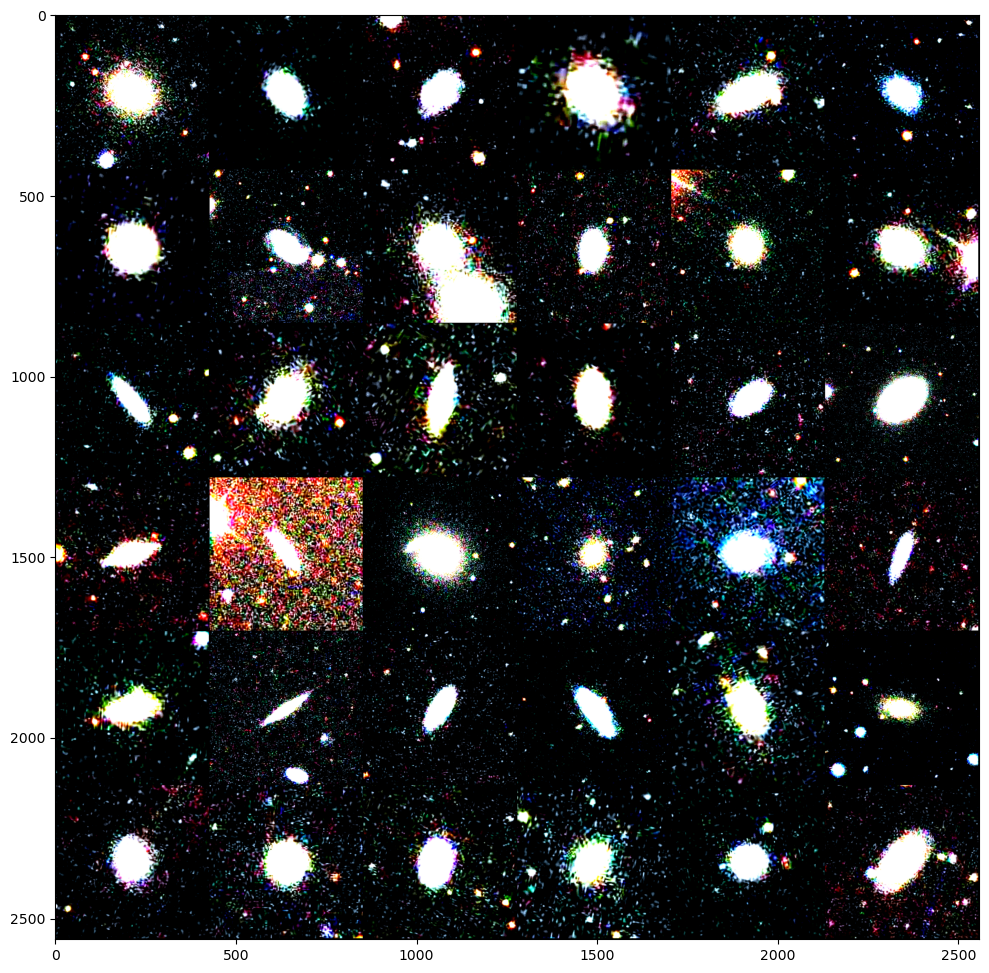

In [19]:
def show_transformed_images(dataset):
    Loader = torch.utils.data.DataLoader(dataset,
                                         batch_size = 36,
                                         shuffle    = True)
    batch = next(iter(Loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images,
                                       nrow = 6)
    
    plt.figure(figsize = (12,12))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels', labels)
    
show_transformed_images(train_dataset)

Section 3 : Creating Neural Network

In [20]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size  = batch_size, shuffle = False)

In [22]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    
    device = torch.device('cpu')
    best_acc = 0
    
    for epoch in range(n_epochs):
        print("Epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0
        running_correct = 0
        total = 0

        start_time = time.time()

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()
            
            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * running_correct / total

        end_time = time.time() 
        epoch_time = end_time - start_time

        print("  - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f. Time taken: %.2fs"
              % (running_correct, total, epoch_acc, epoch_loss, epoch_time))

    test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

    if (test_dataset_acc > best_acc):
        best_acc = test_dataset_acc
        save_checkpoint(model, epoch, optimizer, best_acc)

    print("Finished")
    return model


In [23]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total                        = 0
    device                       = torch.device('cpu')

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100 * predicted_correctly_on_epoch / total
    print("  - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
            % (predicted_correctly_on_epoch, total, epoch_acc))

    return epoch_acc
        

In [24]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'best_accuracy' : best_acc,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [25]:
resnet18_model    = models.resnet18(pretrained = False)

num_ftrs          = resnet18_model.fc.in_features

number_of_classes = 3

resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)

resnet_18_model   = resnet18_model.to('cpu')

loss_fn           = nn.CrossEntropyLoss()

optimizer         = optim.SGD(resnet18_model.parameters(), lr = .01, momentum = 0.9)                      

/home/lewis/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lewis/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 75)

Epoch number 1
  - Training dataset. Got 4138 out of 6691 images correctly (61.844%). Epoch loss: 0.793. Time taken: 1048.09s
Epoch number 2
  - Training dataset. Got 4760 out of 6691 images correctly (71.140%). Epoch loss: 0.649. Time taken: 1075.46s
Epoch number 3
  - Training dataset. Got 4956 out of 6691 images correctly (74.070%). Epoch loss: 0.604. Time taken: 1097.22s
Epoch number 4
  - Training dataset. Got 4963 out of 6691 images correctly (74.174%). Epoch loss: 0.590. Time taken: 1035.48s
Epoch number 5
